In [1]:
import numpy as np
from numpy import pi, sqrt, sinh
from scipy.special import ellipk


In [2]:
# Free-space permittivity (F/m)
eps0 = 8.854187817e-12  
mu0 = 1.25e-6  

In [3]:
def calc_Ccpw(S, W, h1, eps_r1):
    """
    Computes the CPW capacitance per unit length (Ccpw) for 
    a coplanar waveguide of center conductor width S, gap W, 
    dielectric height h1, and relative permittivity eps_r1.

    Parameters
    ----------
    S : float
        Center conductor width
    W : float
        Gap width
    h1 : float
        Substrate thickness (dielectric height)
    eps_r1 : float
        Relative permittivity of the substrate

    Returns
    -------
    float
        The CPW capacitance per unit length in Farads/meter
    """

    

    # Define k0 and its complement k0'
    k0  = S / (S + 2.0 * W)
    k0p = sqrt(1.0 - k0**2)

    # Define k1 and its complement k1'
    k1  = sinh(np.pi * S / (4.0 * h1)) / sinh(np.pi * (S + 2.0 * W) / (4.0 * h1))
    k1p = sqrt(1.0 - k1**2)

    # Complete elliptic integrals of the first kind, 
    # noting that scipy.special.ellipk() uses the parameter m = k^2
    Kk0  = ellipk(k0**2)
    Kk0p = ellipk(k0p**2)
    Kk1  = ellipk(k1**2)
    Kk1p = ellipk(k1p**2)
    #Kk0  = ellipk(k0)
    #Kk0p = ellipk(k0p)
    #Kk1  = ellipk(k1)
    #Kk1p = ellipk(k1p)

    # Calculate the two terms in Ccpw
    term1 = 2.0 * eps0 * (eps_r1 - 1.0) * (Kk1 / Kk1p)
    term2 = 4.0 * eps0 * (Kk0 / Kk0p)

    Ccpw = term1 + term2
    Lcpw = (mu0/4) * (Kk0p/Kk0)
    

    # Return total Ccpw in F/m, Lcpw in L/m
    return Ccpw, Lcpw

In [4]:
def ki_induct_cpw(s,RN_ps,Tc):
    kB = 1.38064852e-23
    hbar = 1.0545718e-34
    delta_0 = 2.08*kB*Tc
    Lk_ps = hbar*RN_ps/(np.pi*delta_0)
    print(Lk_ps)
    Lk = Lk_ps/s
    return Lk

In [5]:
def ki_induct(Lk_ps,S,W):
    k0  = S / (S + 2.0 * W)
    k0p = np.sqrt(1.0 - k0**2) 
    Kk0  = ellipk(k0**2)
    Kk0p = ellipk(k0p**2)
    g = 0.5*np.pi*Kk0p/Kk0
    print('g=',g)
    Lk = g*Lk_ps/S
    return Lk

In [6]:
Ccpw,Lcpw = calc_Ccpw(S=30e-6, W=4e-6, h1=350e-6, eps_r1=11.7)

In [7]:
#Lk = ki_induct_cpw(s=6e-6,RN_ps=503,Tc=7.2)
Lk = ki_induct(Lk_ps=35e-12,S=30e-6,W=4e-6)
#Lk = 0.0

g= 1.400786066889522


In [8]:
Ltot = Lcpw+Lk
Zcpw =np.sqrt(Ltot/Ccpw)
print("Zcpw = ", Zcpw)

Zcpw =  87.11320751584373


In [9]:
Lk/(Lk+Lcpw)

0.8543188549238513

In [10]:
l = 0.00270
(1/(4*np.sqrt((Lcpw+Lk)*l*Ccpw*l)))/1e9

4.216592556341305

In [11]:
# ---- inputs ---------------------------------------------------------------
l_list      = np.array([3059+250,2780+250, 2550+250, 2350+250,])   # μm
Lk_ps_list  = np.array([10, 25, 35])                               # pH/□

# ---- allocate 2-D results array: shape = (n_Lk , n_l) ---------------
f_list = np.zeros((len(Lk_ps_list), len(l_list)))                  # GHz

# ---- compute f for every (Lk_ps , l) pair -------------------------------
for i, Lk_ps in enumerate(Lk_ps_list):
    # sheet-inductance for this row (convert pH/□ → H/□)
    Lk_sheet = ki_induct(Lk_ps=Lk_ps * 1e-12, S=30e-6, W=4e-6)

    # geometry-dependent CPW per-length C and L (same for all l)
    Ccpw, Lcpw = calc_Ccpw(S=30e-6, W=4e-6, h1=350e-6, eps_r1=11.7)

    for j, l in enumerate(l_list):
        Ltot = (Lcpw + Lk_sheet) * l * 1e-6   # total inductance (H)
        Ctot =  Ccpw * l * 1e-6               # total capacitance (F)
        f_list[i, j] = 1 / (4 * np.sqrt(Ltot * Ctot)) / 1e9        # GHz

        

g= 1.400786066889522
g= 1.400786066889522
g= 1.400786066889522


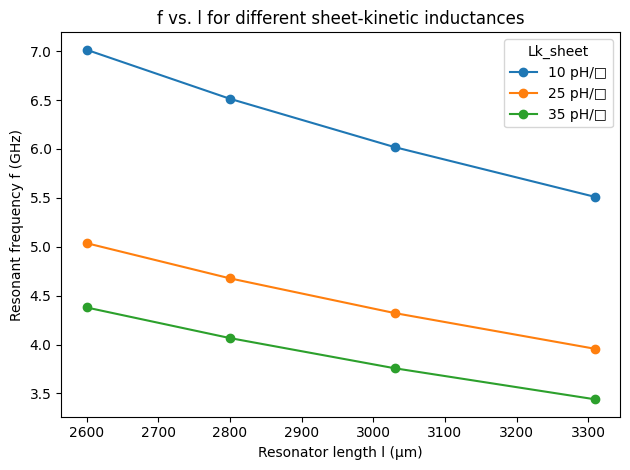

In [12]:
import matplotlib.pyplot as plt
plt.figure()
for i, Lk_ps in enumerate(Lk_ps_list):
    plt.plot(l_list, f_list[i], marker='o', label=f'{Lk_ps} pH/□')

plt.xlabel('Resonator length l (μm)')
plt.ylabel('Resonant frequency f (GHz)')
plt.title('f vs. l for different sheet-kinetic inductances')
plt.legend(title='Lk_sheet')
plt.tight_layout()
plt.show()

In [13]:
import coplanar_coupler

In [14]:
cpw_c = coplanar_coupler.coplanar_coupler()
cpw_c.w1 = 30
cpw_c.w2 = 30
cpw_c.w3 = 5
cpw_c.s1 = 4
cpw_c.s2 = 4
cpw_c.epsilon_eff = 11.75/2
cpw_c.lk = 0

In [15]:
Cl, Ll, Zl = cpw_c.coupling_matrices(mode='notch')
#gamma_numerical = np.sqrt(np.linalg.det(Zl)/(Zl[0,0]*Zl[1,1]))
#kappa_numerical = Zl[0,1]/(np.sqrt(Zl[0,0]*Zl[1,1])*gamma_numerical)
#Z1_numerical = Zl[0,0]/gamma_numerical
#Z2_numerical = Zl[1,1]/gamma_numerical

In [16]:
lc = 250e-6
fr = 4.4e9
cl = 1.0/np.sqrt((Ll[0,0]+Lk)*Cl[0,0])
kappa = Ll[0,1]/np.sqrt((Ll[0,0]+Lk)*(Ll[1,1]+Lk))
p = 1
theta = 2*np.pi*fr*lc/cl
Qc = (np.pi*(2*p-1))/(2*(kappa*np.sin(theta))**2)
print("Qc = ", Qc)


Qc =  166342.69156319564


In [17]:
Ll

array([[2.86573892e-07, 4.05343276e-08],
       [4.05343276e-08, 2.86573892e-07]])

In [18]:
cw_list= np.linspace(5, 25, 5)
Qc_list = []

for cw in cw_list:
    cpw_c = coplanar_coupler.coplanar_coupler()
    cpw_c.w1 = 30
    cpw_c.w2 = 30
    cpw_c.w3 = cw
    cpw_c.s1 = 4
    cpw_c.s2 = 4
    cpw_c.epsilon_eff = 11.75/2
    cpw_c.lk = 0
    Cl, Ll, Zl = cpw_c.coupling_matrices(mode='notch')
    lc = 250e-6
    fr = 4.4e9
    cl = 1.0/np.sqrt((Ll[0,0]+0.0)*Cl[0,0])
    kappa = Ll[0,1]/np.sqrt((Ll[0,0]+0.0)*(Ll[1,1]+0.0))
    p = 1
    theta = 2*np.pi*fr*lc/cl
    Qc = (np.pi*(2*p-1))/(2*(kappa*np.sin(theta))**2)
    Qc_list.append(Qc)


In [19]:
from matplotlib import pyplot as plt

In [20]:
cw_list= np.linspace(5, 25, 5)
Qc_list_k = []

for cw in cw_list:
    cpw_c = coplanar_coupler.coplanar_coupler()
    cpw_c.w1 = 30
    cpw_c.w2 = 30
    cpw_c.w3 = cw
    cpw_c.s1 = 4
    cpw_c.s2 = 4
    cpw_c.epsilon_eff = 11.75/2
    cpw_c.lk = Lk
    Cl, Ll, Zl = cpw_c.coupling_matrices(mode='notch')
    lc = 250e-6
    fr = 4.4e9
    cl = 1.0/np.sqrt((Ll[0,0]+Lk)*Cl[0,0])
    kappa = Ll[0,1]/np.sqrt((Ll[0,0]+Lk)*(Ll[1,1]+Lk))
    p = 1
    theta = 2*np.pi*fr*lc/cl
    Qc = (np.pi*(2*p-1))/(2*(kappa*np.sin(theta))**2)
    Qc_list_k.append(Qc)

Text(0, 0.5, 'Qc')

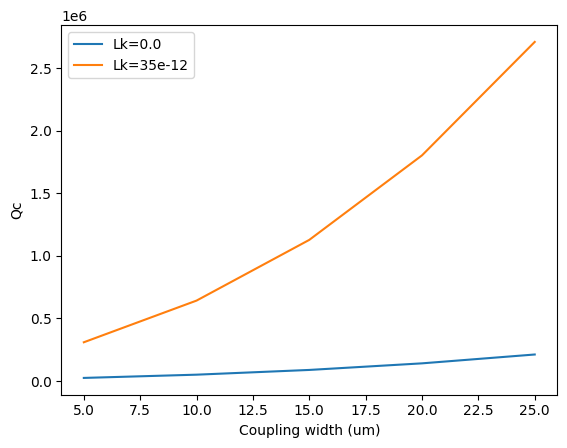

In [21]:
plt.plot(cw_list, Qc_list, label='Lk=0.0')
plt.plot(cw_list, Qc_list_k, label='Lk=35e-12')
plt.xlabel('Coupling width (um)')
plt.legend()
plt.ylabel('Qc')